# TP1 : First order methods on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 9th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 3 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [76]:
# Change here using YOUR first and last names
fn1 = "camille"
ln1 = "masset"
fn2 = "boris"
ln2 = "muzellec"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_masset_camille_and_muzellec_boris.ipynb


In [77]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [78]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

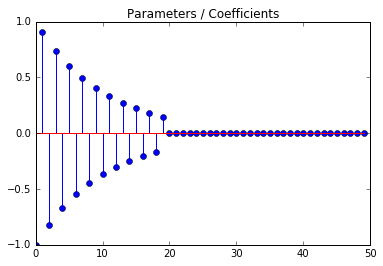

In [79]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (-1) ** (idx - 1) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [80]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)
    out[idx] = 1. / (1 + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b[:] = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

## Questions

- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 

In [81]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""
    return np.multiply(np.sign(x),np.maximum(np.absolute(x) - s*t,0))
    
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    return s*np.linalg.norm(x,1)

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x with strength t"""    
    return 1 / (1+s*t) * x
    
def ridge(x, s):
    """Value of the ridge penalization at x with strength t"""
    return s / 2 * np.linalg.norm(x,2) ** 2

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

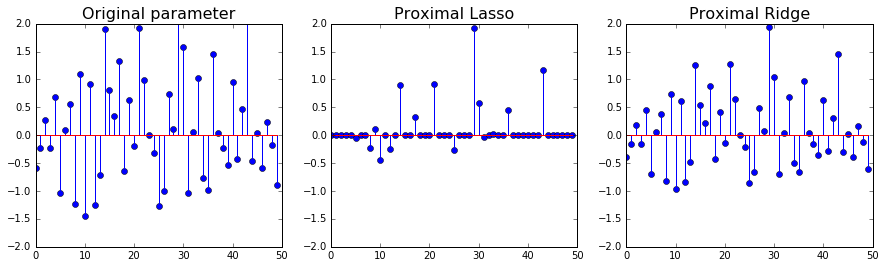

In [82]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

## Question

- Comment what you observe (1 or 2 sentences).

Proximal Lasso induces sparsity: all coefficients with absolute value under $s\cdot t$ vanish, and the others have their absolute value reduced by $s\cdot t$.

Proximal Ridge has a less violent action: it scales down coefficients (by the same factor $\frac{1}{1+s\cdot t}$), but no coefficient vanishes.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

**Questions**:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model

In [83]:
def loss_linreg(x):
    """Least-squares loss"""
    return np.linalg.norm(b - A.dot(x))**2 / (2*A.shape[0])

def grad_linreg(x):
    """Leas-squares gradient"""
    return A.T.dot(A.dot(x)-b)/A.shape[0]

def loss_logreg(x):
    """Logistic loss"""
    return np.log(1+np.exp(-np.multiply(b,A.dot(x)))).sum()/A.shape[0]

def grad_logreg(x):
    """Logistic gradient"""
    return -np.multiply(b,A.dot(sig(-np.multiply(b,A.dot(x)))))/A.shape[0]

# TO BE COMPLETED

In [84]:
from scipy.optimize import check_grad

print(check_grad(loss_linreg,grad_linreg,randn(50)*1e+03))

2.40211836948


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:

- Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function `numpy.linalg.norm` (read the documentation
  of the function)

- Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms

In [85]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    return np.linalg.norm(A.T.dot(A),2)/A.shape[0]
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    return lip_linreg(A)/4
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    from scipy.optimize import check_grad
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape
    
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print ("Lauching ISTA solver...")
        print (' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_g(x - step*grad_f(x))
        
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print (' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [86]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print ("Lauching FISTA solver...")
        print (' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x_new = prox_g(z-step*grad_f(z))
        t_new = (1 + np.sqrt(1+4*t**2))/2
        z_new = x_new + (t-1)/t_new * (x_new-x)
        x, z, t = x_new, z_new, t_new
        
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print (' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [87]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 100
s = 1e-2

**Questions**

- Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

In [88]:

coefs = randn(n_features)
A,b = simu_linreg(coefs, n_samples=1000, corr=0.5)

#ISTA
L = lip_linreg(A)

x1,obj1,err1 = ista(x0, loss_linreg, grad_linreg, ridge, lambda x : prox_ridge(x,s,1/L), 1/L, s, n_iter,
         x_true=coefs, verbose=True)

x2, obj2, err2 = fista(x0, loss_linreg, grad_linreg, ridge, lambda x : prox_ridge(x,s,1/L), 1/L, s, n_iter,
         x_true=coefs, verbose=True)



Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 7.50e+00 | 7.54e-01
      10 | 9.91e-01 | 2.00e-01
      20 | 7.59e-01 | 8.67e-02
      30 | 7.37e-01 | 5.79e-02
      40 | 7.35e-01 | 5.08e-02
      50 | 7.34e-01 | 4.89e-02
      60 | 7.34e-01 | 4.82e-02
      70 | 7.34e-01 | 4.80e-02
      80 | 7.34e-01 | 4.79e-02
      90 | 7.34e-01 | 4.79e-02
     100 | 7.34e-01 | 4.79e-02
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 7.50e+00 | 7.54e-01
      10 | 7.44e-01 | 4.98e-02
      20 | 7.35e-01 | 4.81e-02
      30 | 7.35e-01 | 4.84e-02
      40 | 7.34e-01 | 4.77e-02
      50 | 7.34e-01 | 4.79e-02
      60 | 7.34e-01 | 4.78e-02
      70 | 7.34e-01 | 4.79e-02
      80 | 7.34e-01 | 4.79e-02
      90 | 7.34e-01 | 4.79e-02
     100 | 7.34e-01 | 4.79e-02


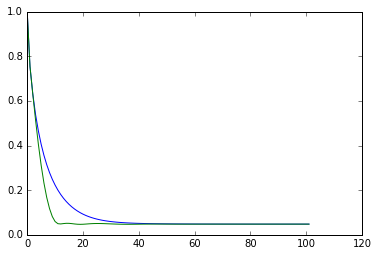

In [91]:
plt.plot(np.arange(len(err1)),err1)
plt.plot(np.arange(len(err2)),err2)

**Questions**

- In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain